In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super().__init__()
        self.fc1  = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # mean
        self.fc22 = nn.Linear(400, latent_dim)  # log-var
        self.fc3  = nn.Linear(latent_dim, 400)
        self.fc4  = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [ ]:

def loss_bce(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

def loss_mse(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD, MSE, KLD

In [ ]:

transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True,  download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader  = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader   = DataLoader(test_dataset,  batch_size=64,  shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.32MB/s]


In [ ]:
def train_vae(model, train_loader, optimizer, loss_fn, epochs=10):
    model.train()
    losses, recon_losses, kld_losses = [], [], []
    for epoch in range(epochs):
        total_loss = total_recon = total_kld = 0.0
        for batch, _ in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss, recon, kld = loss_fn(recon_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_recon += recon.item()
            total_kld   += kld.item()
        n = len(train_loader.dataset)
        losses.append(total_loss/n)
        recon_losses.append(total_recon/n)
        kld_losses.append(total_kld/n)
        print(f"Epoch {epoch+1:2d} | total={losses[-1]:.4f} | recon={recon_losses[-1]:.4f} | kld={kld_losses[-1]:.4f}")
    return losses, recon_losses, kld_losses

In [ ]:

latent_dim = 20
vae_bce = VAE(latent_dim).to(device)
opt_bce = torch.optim.Adam(vae_bce.parameters(), lr=1e-3)

vae_mse = VAE(latent_dim).to(device)
opt_mse = torch.optim.Adam(vae_mse.parameters(), lr=1e-3)

print("Training VAE with BCE reconstruction loss")
losses_bce, recon_bce, kld_bce = train_vae(vae_bce, train_loader, opt_bce, loss_bce, epochs=50)

print("\nTraining VAE with MSE reconstruction loss")
losses_mse, recon_mse, kld_mse = train_vae(vae_mse, train_loader, opt_mse, loss_mse, epochs=50)

Training VAE with BCE reconstruction loss
Epoch  1 | total=165.2120 | recon=150.0482 | kld=15.1639
Epoch  2 | total=121.6960 | recon=99.8648 | kld=21.8312
Epoch  3 | total=114.4074 | recon=90.6977 | kld=23.7097
Epoch  4 | total=111.4431 | recon=87.1365 | kld=24.3066
Epoch  5 | total=109.7594 | recon=85.1645 | kld=24.5949
Epoch  6 | total=108.5905 | recon=83.8288 | kld=24.7618
Epoch  7 | total=107.7774 | recon=82.8487 | kld=24.9287
Epoch  8 | total=107.0913 | recon=82.0980 | kld=24.9933
Epoch  9 | total=106.6337 | recon=81.5734 | kld=25.0603
Epoch 10 | total=106.1788 | recon=81.0688 | kld=25.1100
Epoch 11 | total=105.9100 | recon=80.7087 | kld=25.2013
Epoch 12 | total=105.5649 | recon=80.3369 | kld=25.2280
Epoch 13 | total=105.2958 | recon=80.0456 | kld=25.2502
Epoch 14 | total=105.0605 | recon=79.7689 | kld=25.2915
Epoch 15 | total=104.8035 | recon=79.5119 | kld=25.2916
Epoch 16 | total=104.6114 | recon=79.3073 | kld=25.3041
Epoch 17 | total=104.4813 | recon=79.1348 | kld=25.3465
Epoch

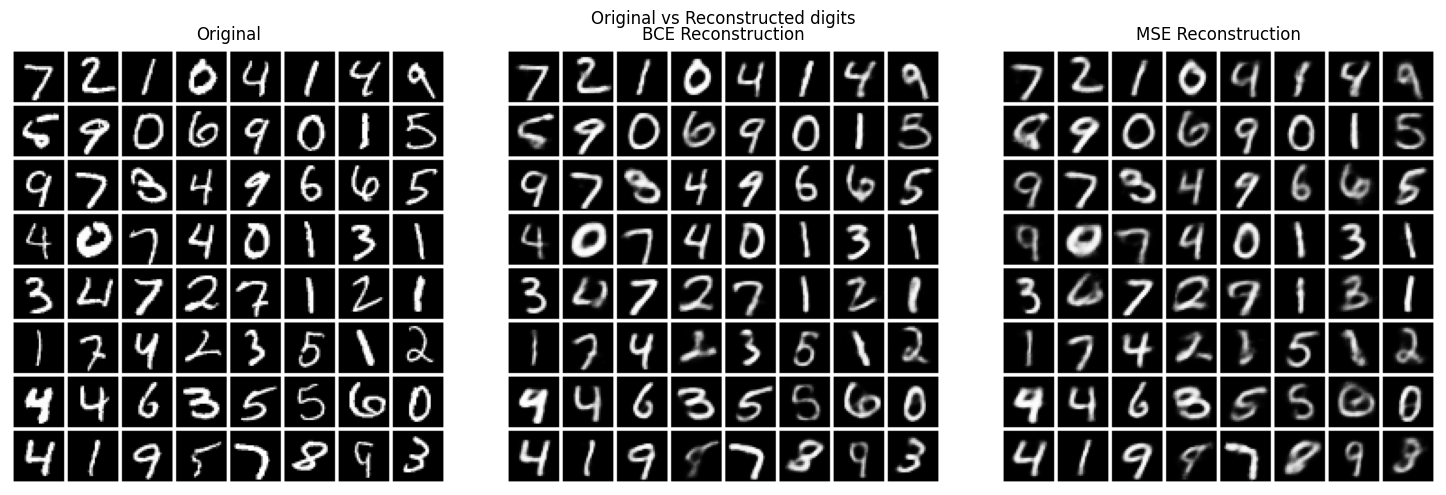

In [ ]:

def to_img_grid(tensor, nrow=8):
    grid = vutils.make_grid(tensor.cpu(), nrow=nrow, padding=2, pad_value=1)
    return grid.numpy().transpose(1,2,0)

data_fixed, labels_fixed = next(iter(test_loader))
data_fixed = data_fixed.to(device)

vae_bce.eval(); vae_mse.eval()
with torch.no_grad():
    recon_bce_fixed = vae_bce(data_fixed)[0].view(-1,1,28,28)
    recon_mse_fixed = vae_mse(data_fixed)[0].view(-1,1,28,28)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(to_img_grid(data_fixed), cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("BCE Reconstruction"); plt.imshow(to_img_grid(recon_bce_fixed), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("MSE Reconstruction"); plt.imshow(to_img_grid(recon_mse_fixed), cmap='gray'); plt.axis('off')
plt.suptitle("Original vs Reconstructed digits")
plt.tight_layout(); plt.show()

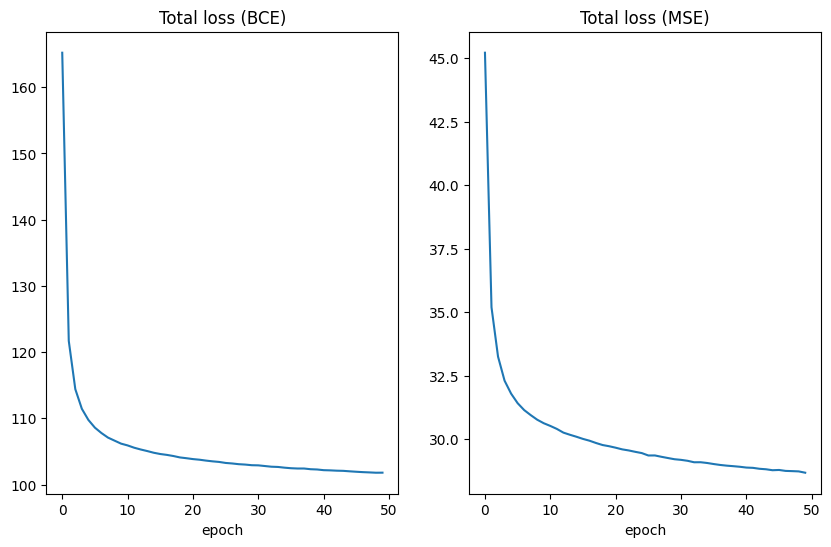

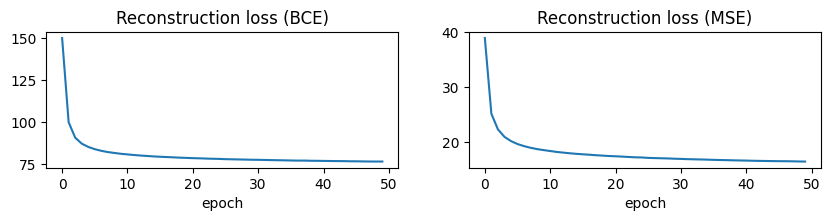

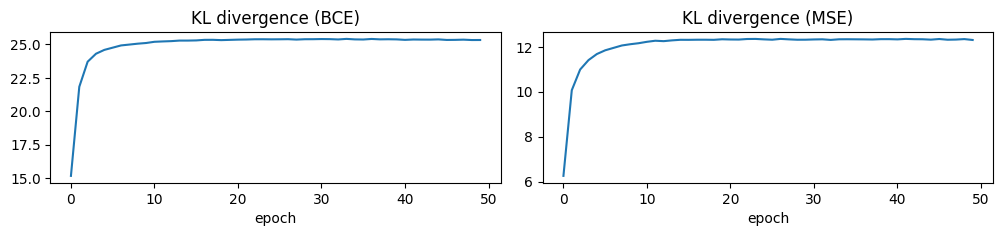

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1); plt.plot(losses_bce); plt.title("Total loss (BCE)"); plt.xlabel("epoch")
plt.subplot(1,2,2); plt.plot(losses_mse); plt.title("Total loss (MSE)"); plt.xlabel("epoch")

plt.figure(figsize=(10,6))
plt.subplot(3,2,3); plt.plot(recon_bce); plt.title("Reconstruction loss (BCE)"); plt.xlabel("epoch")
plt.subplot(3,2,4); plt.plot(recon_mse); plt.title("Reconstruction loss (MSE)"); plt.xlabel("epoch")

plt.figure(figsize=(10,6))
plt.subplot(3,2,5); plt.plot(kld_bce); plt.title("KL divergence (BCE)"); plt.xlabel("epoch")
plt.subplot(3,2,6); plt.plot(kld_mse); plt.title("KL divergence (MSE)"); plt.xlabel("epoch")

plt.tight_layout(); plt.show()
